In [1]:
import pandas as pd
from pathlib import Path
import re
from tqdm import tqdm

In [2]:
# Функция для извлечения из имени файла: Tout (может быть отрицательным), category, type, tube_number, exp_number
# Пример category ideal: 'datasets/Termo_model/Tout_<Tout>/good/Thermo_model_db_n_nodes_ideal.csv'
# Пример category good: 'datasets/Termo_model/Tout_<Tout>/good/Thermo_model_db_n_nodes_V<exp_number>.csv'
# Пример category problem: 'datasets/Termo_model/Tout_<Tout>/problem/tube_<tube_number>/Thermo_model_db_n_nodes_pr<exp_number>.csv'
def parse_filename(nodes_fp):
    nodes_fp = str(nodes_fp)
    edges_fp = nodes_fp.replace('_nodes_', '_tubes_')

    # Извлекаем Tout
    tout_match = re.search(r'Tout_([-+]?\d+\.?\d*)', nodes_fp)
    if tout_match:
        tout = float(tout_match.group(1))
    else:
        raise ValueError(f"Tou value not found in filename: {nodes_fp}")

    ret = dict(
        nodes_fp=nodes_fp,
        edges_fp=edges_fp,
        # nodes_df=pd.read_csv(nodes_fp, sep='\t'),
        # edges_df=pd.read_csv(edges_fp, sep='\t'),
        tout=tout,
        category=None,
        exp_number=None,
        tube_number=None
    )
    # Извлекаем category
    if 'ideal' in nodes_fp:
        ret['category'] = 'ideal'
    elif 'good' in nodes_fp:
        ret['category'] = 'good'
        ret['exp_number'] = re.search(r'V(\d+)', nodes_fp).group(1)
    elif 'problem' in nodes_fp:
        ret['category'] = 'problem'
        ret['tube_number'] = re.search(r'tube_(\d+)', nodes_fp).group(1)
        ret['exp_number'] = re.search(r'pr(\d+)', nodes_fp).group(1)
    else:
        raise ValueError(f"Unknown category in filename: {nodes_fp}")

    return ret

In [3]:
root_dir = 'datasets/Termo_model/'

# Получить все файлы в директории
files = sorted(list(Path(root_dir).glob('**/*nodes*.csv')))

In [4]:
data_by_category = {
    'ideal': [],
    'good': [],
    'problem': []
}
for fp in tqdm(files):
    data = parse_filename(fp)
    data_by_category[data['category']].append(data)

# Сортируем по Tout, tube_number и exp_number
for category in data_by_category:
    data_by_category[category].sort(key=lambda x: (x['tout'], x.get('tube_number', ''), x.get('exp_number', '')))

100%|██████████| 42570/42570 [00:00<00:00, 408293.21it/s]


In [5]:
for d in data_by_category['ideal'][:3]:
    print(d['nodes_fp'], d['tout'], d['category'])

datasets/Termo_model/Tout_-34/good/Thermo_model_db_n_nodes_ideal.csv -34.0 ideal
datasets/Termo_model/Tout_-33/good/Thermo_model_db_n_nodes_ideal.csv -33.0 ideal
datasets/Termo_model/Tout_-32/good/Thermo_model_db_n_nodes_ideal.csv -32.0 ideal


In [6]:
# Объединить таблицы nodes и edges по data_list
def combine_data(data_list):
    combined_nodes = pd.concat([pd.read_csv(d['nodes_fp'], sep='\t') for d in data_list], ignore_index=True)
    combined_edges = pd.concat([pd.read_csv(d['edges_fp'], sep='\t') for d in data_list], ignore_index=True)
    return combined_nodes, combined_edges

<Axes: >

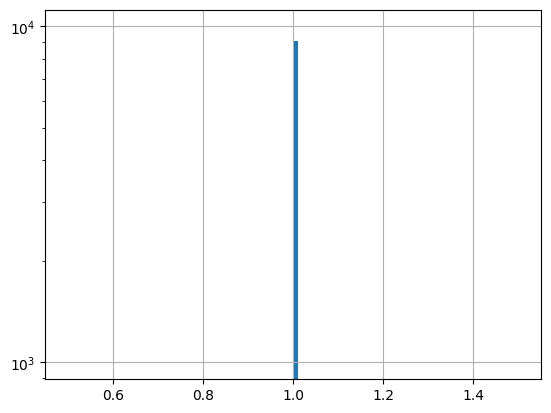

In [7]:
combined_nodes, combined_edges = combine_data(data_by_category['ideal'])
combined_edges['moded'].hist(bins=100, log=True)

<Axes: >

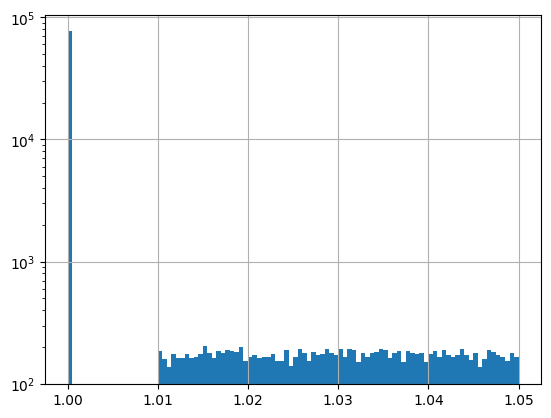

In [8]:
combined_nodes, combined_edges = combine_data(data_by_category['good'])
combined_edges['moded'].hist(bins=100, log=True)

<Axes: >

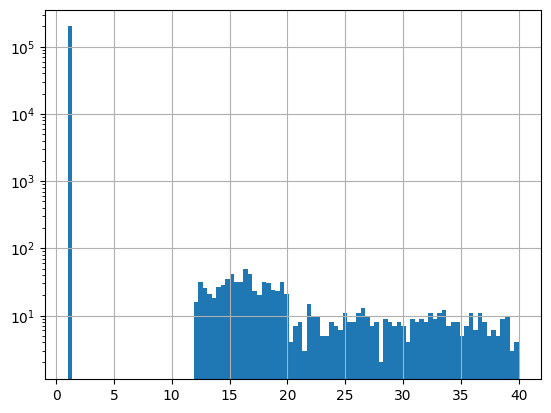

In [9]:
combined_nodes, combined_edges = combine_data(data_by_category['problem'][:1000])
combined_edges['moded'].hist(bins=100, log=True)